## Data analysis for COVID-19

Data extract from github https://github.com/CSSEGISandData/COVID-19.git provided by JHU(johns-hopkins-university) CSSE USA.
Data is first loaded from local repository on my computer (check for last data update). Then, it is converted from raw dataframe table to a more workable dataframe (no coordinates and table trasposition: time as rows, country as columns)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [9]:
# Define path from online repo
repo_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
cases_path = 'master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
recov_path = 'master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
death_path = 'master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'

# Get data from online repo
df_c_raw=pd.read_csv(repo_url+cases_path)
df_d_raw=pd.read_csv(repo_url+death_path)
df_r_raw=pd.read_csv(repo_url+recov_path)

### Recreate data frame as row dates and columns country - region (exclude coordinates)

Write a function to systematically convert all df to my df standard

In [10]:
def recreate_df(raw_df):
    # identify columns and datetime data
    col_names = raw_df.columns
    date_data = pd.to_datetime(raw_df.columns[4:])
    
    # build columns header as country - province (if not empty)
    region_col = pd.Series(data=raw_df['Province/State'], dtype='str')
    country_col = pd.Series(data=raw_df['Country/Region'], dtype='str')
    col_headers = country_col.str.cat(region_col, sep=(' - '))
    col_headers = col_headers.str.rstrip(' nan').str.rstrip(' -')
    
    # Build dataframe without coordinates and with time as row + countries as columns
    new_df = pd.DataFrame(data=date_data, columns=['Date'])
    for cidx, c in enumerate(col_headers):
        data_tmp = np.array(raw_df.iloc[cidx][4:], dtype=int)
        new_df[c] = data_tmp
    return new_df

In [11]:
# reconstruct df from original data
df_c = recreate_df(df_c_raw)
df_d = recreate_df(df_d_raw)
df_r = recreate_df(df_r_raw)

## Study cases in France

Check the current status of diagnosed cases 

In [12]:
# interesting data exist from Feb 23, 2020 then a filter is applied at the plot code area
start_date = '2020-2-23'
mask = df_c.Date > start_date

In [13]:
# Extract all info for mainland France (exclude all other islands)
c_study = 'France - France'
#c_study = 'Mexico'
#c_study = 'Germany'
#c_study = 'Italy'

for cidx, c in enumerate(df_c.columns):
    # check if mainland
    if c == c_study:
        fr_cases = np.array(df_c[c], dtype=int)
        fr_death = np.array(df_d[c], dtype=int)
        fr_recov = np.array(df_r[c], dtype=int)

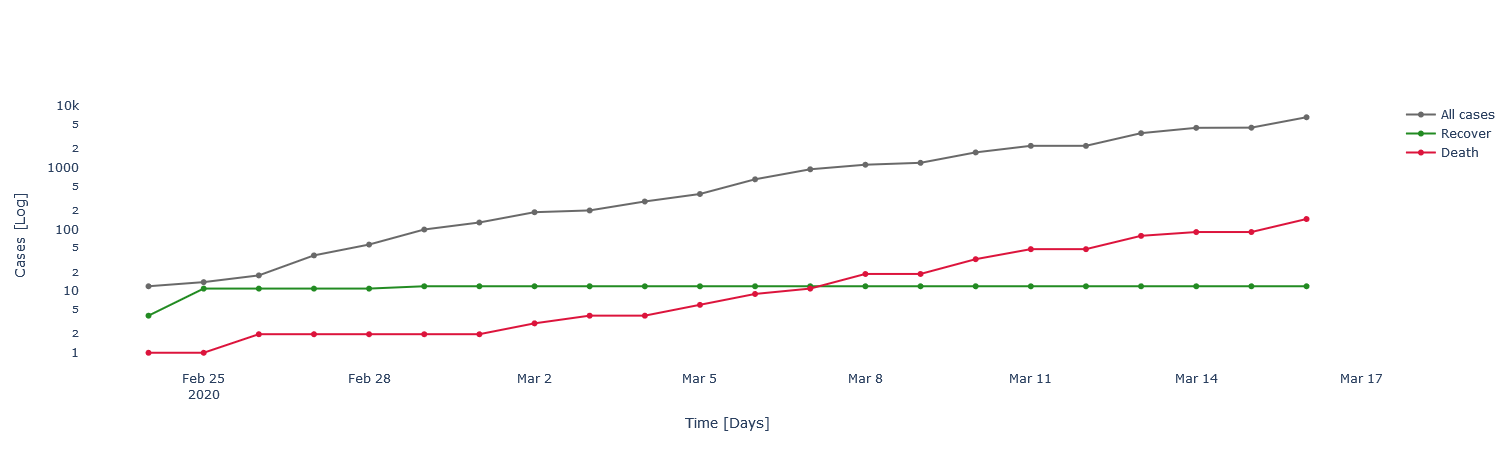

In [14]:
# Build plot for basic data display
fig = go.Figure()
# diagnosed cases
fig.add_trace(
    go.Scatter(
        mode='lines+markers',
        x=df_c.Date[mask], 
        y=fr_cases[mask],  
        name = 'All cases',
        marker=dict(color='DimGray')
))
# recover cases
fig.add_trace(
    go.Scatter(
        mode='lines+markers',
        x=df_c.Date[mask], 
        y=fr_recov[mask],
        name = 'Recover',
        marker=dict(color='forestgreen')
))
# death cases
fig.add_trace(
    go.Scatter(
        mode='lines+markers',
        x=df_c.Date[mask], 
        y=fr_death[mask],  
        name = 'Death',
        marker=dict(color='crimson')
))

if fr_cases.max() > 100:
    fig.update_layout(yaxis_title = 'Cases [Log]', yaxis_type="log")
else:
    fig.update_layout(yaxis_title = 'Cases')
fig.update_layout(
    xaxis_title = 'Time [Days]',
    plot_bgcolor='white',    
)

The evolution of COVID-19 in France is track as a growing desease with almost 50 deaths over ~2000 reported cases and with an small ratio of recover at the moment. Seems like some figures (recovery) has not been fully disclose by the media.
In general COVID-19 as a growing tendency as it is display with all diagnose cases.

### Check extra figures from french data

So far the media has not disclose all the info on regard to recover cases, the ratio of death cases and recover are display per day

In [15]:
def safe_div(x,y): # for arrays
    isZero = (y == 0)
    y2 = np.array(y)
    y2[isZero] = 1
    res = x / y2
    res[isZero] = 0
    return res

In [16]:
rate_recov_d = safe_div(fr_recov, fr_cases) *100
rate_death_d = safe_div(fr_death, fr_cases) *100

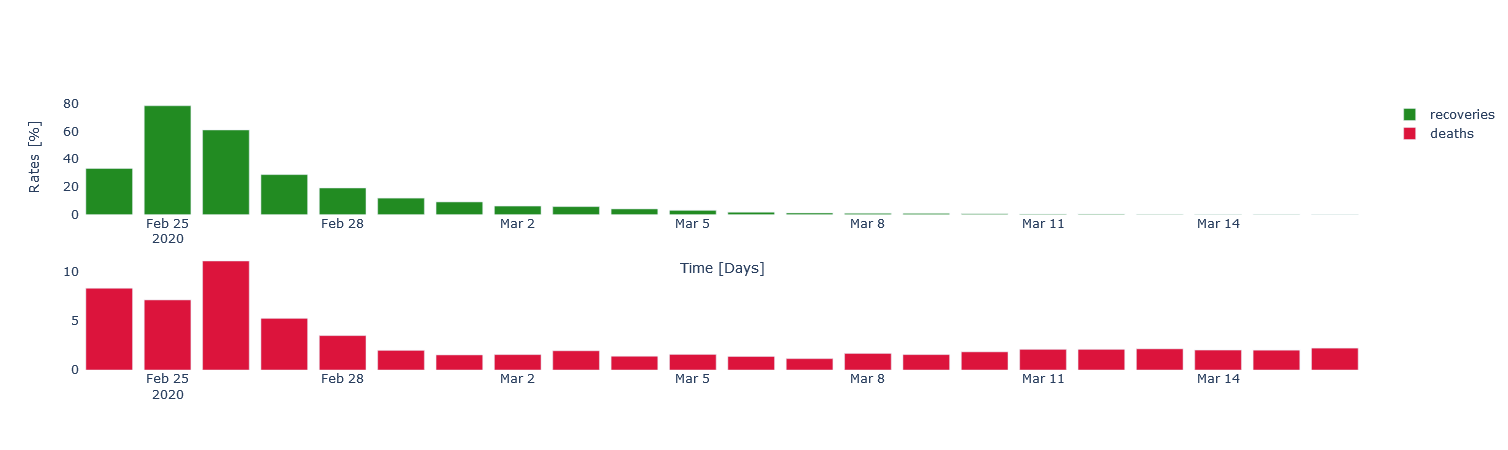

In [17]:
# display rates
fig = make_subplots(rows=2, cols=1)

fig.add_bar(
    row=1, col=1,
    x = df_c.Date[mask],
    y = rate_recov_d[mask],
    name = 'recoveries',
    marker = dict(color = 'forestgreen')
    )
fig.add_bar(
    row=2, col=1,
    x = df_c.Date[mask],
    y = rate_death_d[mask],
    name = 'deaths',
    marker = dict(color = 'crimson')
)
fig.update_layout(
    xaxis_title = 'Time [Days]',
    yaxis_title = 'Rates [%]',
    plot_bgcolor='white')

Data is preseted from 23 Feb 2020, since previous data does not display the disease evolution.

Total death cases has reach a tendency value around ~2 % over the past two weeks. It correspond to a low death ratio compare to the spread in China. However, the statistics on deaths from corona are calculated on the current population infected, a better number can be calculated on regard to the number of close cases and not only open cases (current infected population)

In [18]:
# Daily cases in France
cases_d_fr = fr_cases[1:]-fr_cases[:fr_cases.size-1]
cases_d_fr = np.insert(cases_d_fr, 0, fr_cases[0])
ts_fr = pd.Series(data=fr_cases, index=df_c.Date)

# Daily recovery
recov_d_fr = fr_recov[1:]-fr_recov[:fr_recov.size-1]
recov_d_fr = np.insert(recov_d_fr, 0, fr_recov[0])

# Daily death
death_d_fr = fr_death[1:]-fr_death[:fr_death.size-1]
death_d_fr = np.insert(death_d_fr, 0, fr_recov[0])

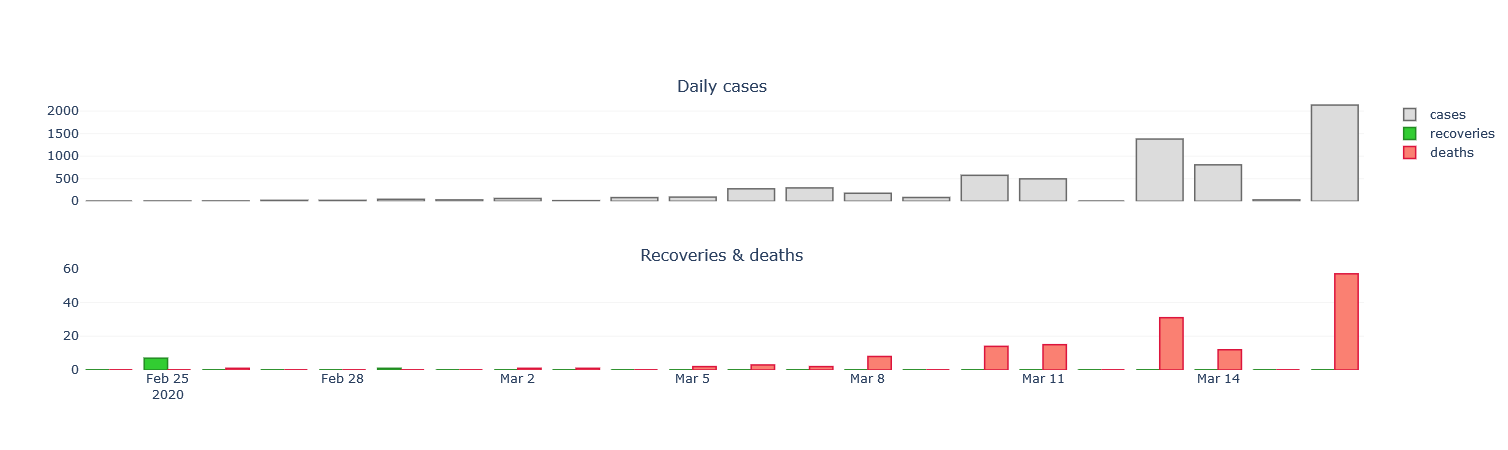

In [19]:
# display daily results into two columns
fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    subplot_titles = ('Daily cases', 'Recoveries & deaths')
                    )
# daily cases
fig.add_trace(go.Bar(
    x = df_c.Date[mask],
    y = cases_d_fr[mask],
    marker = dict(color = 'gainsboro', line = dict(color = 'dimgray', width=1.5)),
    name = 'cases'
    ),
    #secondary_y = False,
    row=1, col=1
)
# daily recoveries
fig.add_trace(go.Bar(
    x = df_c.Date[mask],
    y = recov_d_fr[mask],
    marker = dict(color = 'LimeGreen', line = dict(color = 'ForestGreen', width=1.5)),
    name = 'recoveries'
    ),
    #secondary_y = False,
    row=2, col=1
)
# daily deaths
fig.add_trace(go.Bar(
    x = df_c.Date[mask],
    y = death_d_fr[mask],
    marker = dict(color = 'salmon', line = dict(color = 'crimson', width=1.5)),
    name = 'deaths'
    ),
    #secondary_y = True,              
    row=2, col=1
)

fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(showgrid=True, gridwidth=.3, gridcolor='gainsboro')